# Interpolación polinómica en una variable
#                  con Python

Autor: Pedro González Rodelas

Fecha de la primera versión: 27/08/2017

Fecha de la última revisión: 16/09/2017

Estructura del notebook y algunos ejemplos tomados o adaptados de los libros:

- "Numerical Python: A Practical Techniques Approach for Industry" de Robert Johansson. Edit. Apress (2015) con ISBN-13 (electronic): 978-1-4842-0553-2
- "Numerical Methods in Engineering with Python 3" de Jaan Kiusalaas. Edit Cambridge Univ. Press (2013) con ISBN: 978-1-107-03385-6
- "Análisis Numérico con Mathematica" de V. Ramírez, D. Barrera, M. Pasadas y P. González. Edit. Ariel Ciencia (2001) con ISBN: 84-344-8036-0. Dep. Legal: B.31.425-2001

En esta práctica nos ocuparemos de estudiar los problemas de interpolación polinómica más habituales, comprobando su unisolvencia así como los mejores procedimientos para su resolución computacional. Por otro lado introduciremos también las órdenes de Python que sirven para obtener los polinomios interpoladores correspondientes. 

## Carga de los módulos y 
## Definición de ciertas funciones empleadas

Antes de empezar a realizar cualquier cálculo numérico o simbólico debemos de cargar los correspondientes módulos de Python que implementan la mayoría de funciones y procedimientos necesarios para ello: `NumPy` y `SymPy` que serán cargados con los pseudónimos habituales `np` y `sp`, respectivamente. Además cargaremos la función del módulo random que nos permitirá generar números aleatorios, cada vez que los necesitemos y el submódulo por excelencia para realizar todo tipo gráficos y figuras `MatPlotlib.Pyplot`, con el pseudónimo habitual `plt`. Además en esta práctica usaremos específicamente el submódulo `interpolate` del módulo `SciPy`.

In [1]:
import numpy as np # Importamos el módulo NumPy con el pseudónimo np
import sympy as sp # Importamos el módulo SymPy con el pseudónimo sp
sp.init_printing() # con esta opción obtendremos bonitas fórmulas

In [2]:
# usaremos una opción para poder visualizar los gráficos incrustados 
# en línea dentro de este mismo notebook
%matplotlib inline 
import matplotlib.pyplot as plt  # 

In [3]:
from random import random 
# Importamos la función generadora de números pseudoaleatorios

In [4]:
import timeit # para poder cronometrar la ejecución de ciertos códigos 

In [5]:
from scipy import interpolate # importamos el submódulo interpolate
?interpolate

Como se puede consultar en la documentación correspondiente, este submódulo contiene clases de objetos y funciones que permitirán obtener tanto polinomios de interpolación uni y multi-variada, así como splines para problemas de interpolación de tipo Lagrange, y muchas más posibilidades que no vamos a contemplar de momento.

Por otra parte, también usaremos de vez en cuando una función propia, que vamos a definir a continuación y posteriormente vectorizar, con el objeto de poder redondear por cero cualquier número o lista/array de números en coma flotante que sea menor que un cierto valor máximo, que también podremos indicar opcionalmente, o bien tomar un valor por defecto adecuado para nuestros propósitos. 

In [6]:
from mpmath import chop

In [7]:
?chop

In [8]:
chop(3+1e-16j)

mpf('3.0')

In [9]:
chop([3+1e-16j,3+1e-14j,3+1e-12j,3+1e-6j])

[mpf('3.0'),
 mpf('3.0'),
 mpc(real='3.0', imag='9.9999999999999998e-13'),
 mpc(real='3.0', imag='9.9999999999999995e-7')]

In [11]:
print(chop([1.0, 1e-20, 3+1e-18j, -4, 2]))

[mpf('1.0'), mpf('0.0'), mpf('3.0'), mpf('-4.0'), mpf('2.0')]


In [12]:
def mychop(expr, *, max=10**(-14)): 
    if abs(expr) > max:
      return expr 
    else:
      return 0

In [13]:
chop_vec = np.vectorize(mychop) # versión vectorizada de 'mychop'

In [14]:
?np.product  # así usaremos la función producto de los elementos
# de un array de NumPy

In [15]:
?sum         # información de la orden de sumatoria de los elementos
# de una lista o array

## El submódulo polynomial de NumPy

In [16]:
import numpy.polynomial as P # cargaremos el submódulo polynomial, 
# situado dentro del módulo NumPy, con el pseudónimo P

In [17]:
p1 = P.Polynomial([1,2,3]) # Instancia concreta de la clase Polynomial
# a partir de los coeficientes indicados y la base canónica 1, x, x^2,...
p1

Polynomial([ 1.,  2.,  3.], [-1,  1], [-1,  1])

Nótese que aparte de obtener en una primera lista los coeficientes en la base canónica del polinomio en cuestión, también nos proporciona por defecto un intervalo donde se considera definido y un rango o ventana que nos permitirá focalizar las propiedades concretas de este polinomio, sobre todo si se pretende luego realizar alguna operación integral, como comprobar su ortogonalidad por ejemplo, ya que lo que se proporciona es una transformación lineal (escalado seguido de una traslación) que transforma el dominio del polinomio en otro intervalo de normalización, donde tendrían lugar los cálculos más exigentes a nivel de sensibilidad y número de condición. Por defecto esta afinidad suele ser la identidad en el intervalo $[-1,1]$, aunque como veremos hay otras muchas posibilidades.

In [18]:
p1.coef   # de esta manera podemos recuperar los coeficientes de p1

array([ 1.,  2.,  3.])

In [19]:
p1.domain # así obtendríamos el dominio de definición por defecto

array([-1,  1])

In [20]:
p1.window  # y así la ventana en la que está considerado 
# en este momento

array([-1,  1])

In [21]:
?P.Polynomial # para obtener más información detallada de la orden
# Polynomial, dentro del submódulo numpy.polynomial

Por otra parte, para poder evaluar dicho polinomio en uno o varios valores concretos de la variable $x$, lo que tendremos que hacer es usarlo cómo si fuera una función, ya sea vectorizada o no.

In [22]:
p1(-1),p1(0),p1(1)

Definamos ahora algunas instancias más de esta clase de polinomios y operemos con ellos, usando los operadores habituales de suma (`+`), resta (`-`), producto (`*`) y división entera de polinomios (`//`) desechando el resto si lo hubiera.

In [27]:
p2 = P.Polynomial([1,0,1])
p3 = P.Polynomial([0,1,0])

In [28]:
p2 + p3

Polynomial([ 1.,  1.,  1.], [-1.,  1.], [-1.,  1.])

In [29]:
p2 - p3

Polynomial([ 1., -1.,  1.], [-1.,  1.], [-1.,  1.])

In [30]:
p2*p3

Polynomial([ 0.,  1.,  0.,  1.], [-1.,  1.], [-1.,  1.])

In [31]:
p2//p3  # nótese que el resto de la división polinómica es ignorado

Polynomial([ 0.,  1.], [-1.,  1.], [-1.,  1.])

In [32]:
p3//p2  # nótese que el resto de la división polinómica es ignorado

Polynomial([ 0.], [-1.,  1.], [-1.,  1.])

Aparte de poder representar los polinomios en la base canónica habitual, también podríamos buscar sus correspondientes coeficientes en alguna de las bases de polinomios ortogonales más usados, como por ejemplo de Chebyshev, Legendre, Laguerre, Hermite, etc.

In [33]:
p1bis = P.Chebyshev([1,-2,3])
p1bis.roots()

array([-0.43425855,  0.76759188])

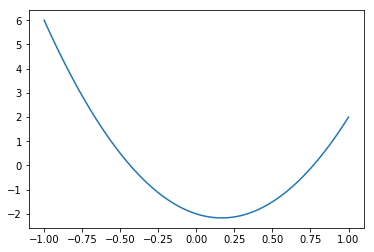

In [34]:
xx = np.linspace(-1,1,100)
yy = p1bis(xx)
plt.plot(xx,yy);

Pero recordemos las opciones para visualizar los ejes $Ox$ y $Oy$ centrados en el origen de coordenadas $(0,0)$.

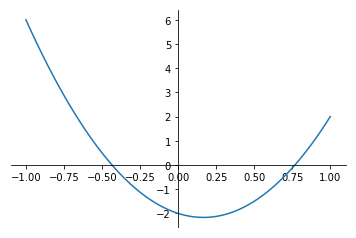

In [35]:
fig, ax = plt.subplots()  # de esta forma generamos una instancia
# de la clase figura, con sus correspondientes ejes 
# y con posibilidad de incluir varios gráficos en ella

# estas opciones evitan que se dibujen
ax.spines['right'].set_color('none')   # tanto el borde derecho
ax.spines['top'].set_color('none') # como el superior del gráfico
 
# mientras que las opciones siguientes sirven
ax.xaxis.set_ticks_position('bottom')
# para fijar la posición de las marcas en la parte inferior 
ax.spines['bottom'].set_position(('data',0)) 
# y situar el eje Ox en la recta horizontal y=0

# y estas para fijar la posición de las marcas 
ax.yaxis.set_ticks_position('left')  # a la izquierda del eje Oy
ax.spines['left'].set_position(('data',0))   
# y situar éste en la recta vertical x=0

# ahora es cuando generamos el gráfico en sí
ax.plot(xx, yy); # como una instancia de la clase ejes

In [36]:
p1,p1bis # distintos tipos de polinomios 

(Polynomial([ 1.,  2.,  3.], [-1,  1], [-1,  1]),
 Chebyshev([ 1., -2.,  3.], [-1,  1], [-1,  1]))

In [37]:
# con los que no se podrá operar directamente entre ellos
# p1 + p1bis  # descomente esta línea de código y compruébelo

## Problemas de interpolación polinómica más habituales

Los problemas de interpolación más habituales son los que involucran datos de la función en ciertos nodos (que se dirán de tipo lagrangiano) o bien de alguna de sus derivadas (que se denominarán de tipo Hermite). Véamos a continuación los casos más simples, pero al mismo tiempo los más empleados. 

### Línea que pasa por dos puntos dados

Calculemos el segmento de línea recta que *interpola* (o pasa por) los datos $(x_L,y_L)$ y $(x_R,y_R)$.

In [38]:
x = sp.Symbol('x')
xL,yL,xR,yR = sp.symbols('xL,yL,xR,yR')

Calculemos el segmento de línea recta que *interpola* (o pasa por) los datos $(x_L,y_L)$ y $(x_R,y_R)$.

In [40]:
c0,c1 = sp.symbols('c0,c1')
p1 = c0+c1*(x-xL)
ec0 = p1.subs({x:xL})-yL
ec1 = p1.subs({x:xR})-yR
ecs = [ec0,ec1]
ecs

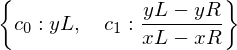

In [41]:
sol1 = sp.solve(ecs,[c0,c1])
sol1

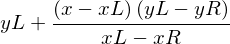

In [42]:
p1.subs(sol1)

In [43]:
def linea(x,xL,yL,xR,yR):
    """linea que pasa por los puntos (xL,yL) y (xR,yR)"""
    return yL+(x-xL)*(yL-yR)/(xL-xR)

In [45]:
linea(x,0,1,1,-1)

### Línea que pasa por un punto y tiene una pendiente fijada

Calculemos el segmento de línea recta que *interpola* (o pasa por) un punto dado $(x_L,y_L)$ y con pendiente $d_L$, cuya expresión se puede obtener muy fácilmente.

In [46]:
x = sp.Symbol('x')
xL,yL,dL = sp.symbols('xL,yL,dL')

In [51]:
p1  = yL+dL*(x-xL) # Esta es claramente la expresión del polinomio de 
dp1 = sp.diff(p1,x)   # grado uno que cumple las condiciones requeridas

In [49]:
p1.subs({x:xL}),dp1 # aquí vemos la correspondiente comprobación

### Parábola que pasa por tres puntos dados

Calculemos ahora el trozo de parábola que *interpola* (o pasa por) los datos $(x_L,y_L)$, $(x_M,y_M)$ y $(x_R,y_R)$.

In [52]:
x = sp.Symbol('x')
xL,yL,xM,yM,xR,yR = sp.symbols('xL,yL,xM,yM,xR,yR')

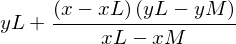

In [53]:
linea(x,xL,yL,xM,yM)

In [55]:
p1 = linea(x,xL,yL,xM,yM)
D2 = sp.Symbol('D2')
p2 = p1 + (x-xL)*(x-xM)*D2
ec2 = p2.subs({x:xR})-yR
sol2 = sp.solve(ec2,D2)
D2 = sol2[0]

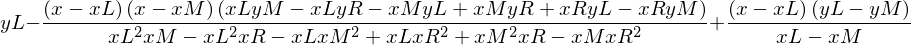

In [57]:
p2 = p1 + (x-xL)*(x-xM)*D2
sp.simplify(p2)

In [59]:
p2.subs({x:xL}),sp.simplify(p2.subs({x:xM})),sp.simplify(p2.subs({x:xR}))

In [60]:
def parabola(x,xL,yL,xM,yM,xR,yR):
    return yL -(x-xL)*(x-xM)*(xL*yM-xL*yR-xM*yL+xM*yR+xR*yL-xR*yM)/(xL**2*xM-xL**2*xR-xL*xM**2+xL*xR**2+xM**2*xR-xM*xR**2)+(x-xL)*(yL-yM)/(xL-xM)

In [61]:
parabola(x,-1,-1,0,2,1,-1).simplify()

**Ejercicio:** Utilice la función `parabola` definida más arriba para calcular varias parábolas bien conocidas, como por ejemplo $x^2$, $-x^2$, etc. introduciendo tres de los puntos por los que se sabe que pasan.

### Parábola que pasa por dos puntos y tiene la pendiente fijada en uno de ellos

Calculemos ahora el trozo de parábola que pasa por los puntos (o *interpola* los datos) $(x_L,y_L)$, $(x_R,y_R)$ y tiene fijada la derivada en uno de ellos.

In [62]:
x = sp.Symbol('x')
xL,yL,xR,yR,d = sp.symbols('xL,yL,xR,yR,d')

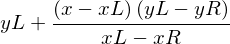

In [63]:
p1 = linea(x,xL,yL,xR,yR)
p1

In [64]:
p1.subs({x:xL}),p1.subs({x:xR}).simplify()

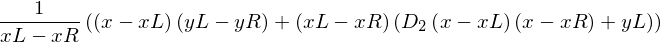

In [65]:
D2 = sp.Symbol('D2')
p2 = p1 + D2*(x-xL)*(x-xR)
p2.simplify()

In [66]:
p2.subs({x:xL}),p2.subs({x:xR}).simplify()

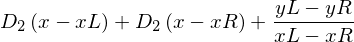

In [68]:
dp2 = sp.diff(p2,x)
dp2

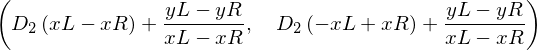

In [69]:
dp2.subs({x:xL}),dp2.subs({x:xR})

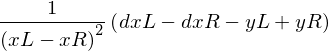

In [70]:
ec2d  = dp2.subs({x:xL})-d
sol2d = sp.solve(ec2d,D2)
D2 = sol2d[0]
D2

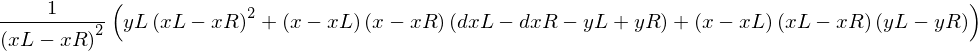

In [71]:
p2d = p1 + D2*(x-xL)*(x-xR)
p2d.simplify()

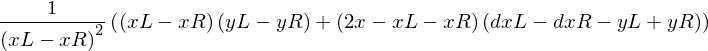

In [73]:
dp2 = sp.diff(p2d,x)
dp2.simplify()

In [74]:
p2d.subs({x:xL}),sp.simplify(p2d.subs({x:xR})),sp.simplify(dp2.subs({x:xL}))

In [75]:
def parabolaconderivada(x,d,xL,yL,xR,yR):
    """parábola con derivada fijada en el primer punto"""
    return (yL*(xL-xR)**2+(x-xL)*(x-xR)*(d*(xL-xR)+(yR-yL))+(x-xL)*(xL-xR)*(yL-yR))/(xL-xR)**2

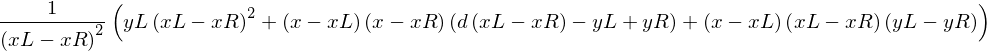

In [76]:
parabolaconderivada(x,d,xL,yL,xR,yR) # comprobemos la expresión

In [77]:
parabolaconderivada(x,d,xL,yL,xR,yR).subs({x:xL})

In [78]:
parabolaconderivada(x,d,xL,yL,xR,yR).subs({x:xR}).simplify()

In [80]:
sp.diff(parabolaconderivada(x,d,xL,yL,xR,yR),x).subs({x:xL}).simplify()

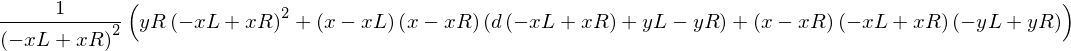

In [81]:
parabolaconderivada(x,d,xR,yR,xL,yL) # y veámos que pasa al
# intercambiar los puntos (xL,yL) y (xR,yR).

In [82]:
parabolaconderivada(x,d,xR,yR,xL,yL).subs({x:xR})

In [83]:
parabolaconderivada(x,d,xR,yR,xL,yL).subs({x:xL}).simplify()

In [85]:
sp.diff(parabolaconderivada(x,d,xR,yR,xL,yL),x).subs({x:xR}).simplify()

Veámos por último un simple ejemplo con datos concretos

$$p'(0)=1,\; p(0)=1,\; p(1)=1 $$

In [88]:
a = 0; b = 1; d = -1; ya = 1; yb = 1
z = sp.Symbol('z')
p2 = parabolaconderivada(z,d,a,ya,b,yb)
p2.expand()

In [89]:
def p(x):
    return p2.subs({z:x})
p(0),p(1)

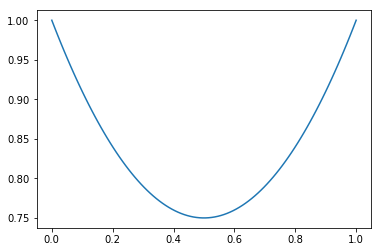

In [90]:
nxx = 100
xx = np.linspace(a,b,nxx)
yy = [p(x) for x in xx]
plt.plot(xx,yy);

### Cúbica que pasa por cuatro puntos

In [91]:
x = sp.Symbol('x')
x1,y1,x2,y2,x3,y3,x4,y4 = sp.symbols('x1,y1,x2,y2,x3,y3,x4,y4')

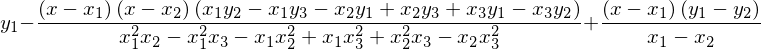

In [92]:
p2 = parabola(x,x1,y1,x2,y2,x3,y3).simplify()
p2

In [93]:
p2.subs({x:x1}),p2.subs({x:x2}).simplify(),p2.subs({x:x3}).simplify()

In [94]:
D3 = sp.Symbol('D3')
p3 = p2 + D3*(x-x1)*(x-x2)*(x-x3)
ec3 = p3.subs({x:x4})-y4
sol3 = sp.solve(ec3,D3)
D3 = sol3[0].simplify()

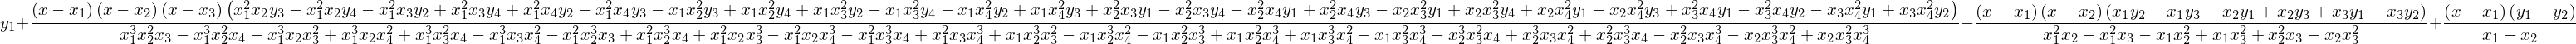

In [95]:
p3 = p2 + D3*(x-x1)*(x-x2)*(x-x3)
p3

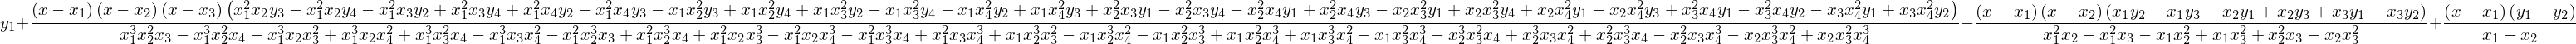

In [96]:
p3.simplify()

In [97]:
def cubica(x,x1,y1,x2,y2,x3,y3,x4,y4):
    """cúbica que pasa por cuatro puntos dados"""
    return y1+(x-x1)*(x-x2)*(x-x3)*(x1**2*x2*y3-x1**2*x2*y4-x1**2*x3*y2+x1**2*x3*y4+x1**2*x4*y2-x1**2*x4*y3-x1*x2**2*y3+x1*x2**2*y4+x1*x3**2*y2-x1*x3**2*y4-x1*x4**2*y2+x1*x4**2*y3+x2**2*x3*y1-x2**2*x3*y4-x2**2*x4*y1+x2**2*x4*y3-x2*x3**2*y1+x2*x3**2*y4+x2*x4**2*y1-x2*x4**2*y3+x3**2*x4*y1-x3**2*x4*y2-x3*x4**2*y1+x3*x4**2*y2)/(x1**3*x2**2*x3-x1**3*x2**2*x4-x1**3*x2*x3**2+x1**3*x2*x4**2+x1**3*x3**2*x4-x1**3*x3*x4**2-x1**2*x2**3*x3+x1**2*x2**2*x4+x1**2*x2*x3**3-x1**2*x2*x4**3-x1**2*x3**3*x4+x1**2*x3*x4**3+x1*x2**3*x3**2-x1*x2**3*x4**2-x1*x2**2*x3**3+x1*x2**2*x4**3+x1*x3**3*x4**2-x1*x3**2*x4**3-x2**3*x3**2*x4+x2**3*x3*x4**2+x2**2*x3**3*x4-x2**2*x3*x4**3-x2*x3**3*x4**2+x2*x3**2*x4**3)-(x-x1)*(x-x2)*(x1*y2-x1*y3-x2*y1+x2*y3+x3*y1-x3*y2)/(x1**2*x2-x1**2*x3-x1*x2**2+x1*x3**2+x2**2*x3-x2*x3**2)+(x-x1)*(y1-y2)/(x1-x2)

In [98]:
cubica(x,-1,1,0,0,1,1,2,-2).expand()

### Cúbica que pasa por dos puntos, especificando también la pendiente en ellos

In [99]:
x = sp.Symbol('x')
xL,yL,dL,xR,yR,dR = sp.symbols('xL,yL,dL,xR,yR,dR')

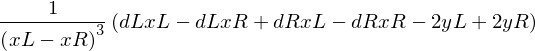

In [100]:
p2 = parabolaconderivada(x,dL,xL,yL,xR,yR)
DR = sp.Symbol('DR')
p3 = p2 + DR*(x-xL)**2*(x-xR) 
dp3 = sp.diff(p3,x)
ec3 = dp3.subs({x:xR}).simplify()-dR
sol3 = sp.solve(ec3,DR)
DR = sol3[0].simplify()
DR

In [101]:
def cubicaconderivadas(x,xL,yL,dL,xR,yR,dR):
    """cúbica con datos de Lagrange y Hermite en ambos extremos"""
    # DR = sp.Symbol('DR')
    # DR = sp.Rational(dL*xL-dL*xR+dR*xL-dR*xR-2*(yL-yR),(xL-xR)**3)
    DR = (dL*xL-dL*xR+dR*xL-dR*xR-2*(yL-yR))/(xL-xR)**3
    return parabolaconderivada(x,dL,xL,yL,xR,yR) + DR*(x-xL)**2*(x-xR)

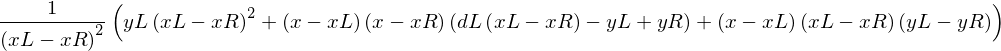

In [102]:
parabolaconderivada(x,dL,xL,yL,xR,yR)

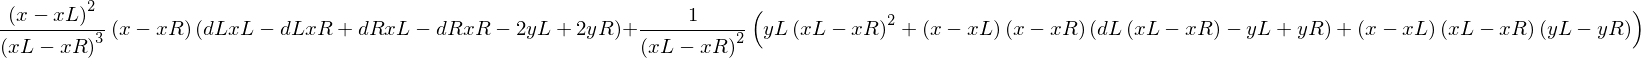

In [103]:
cubicaconderivadas(x,xL,yL,dL,xR,yR,dR)

In [104]:
p1000 = cubicaconderivadas(x,0,1,0,1,0,0).simplify()
p0100 = cubicaconderivadas(x,0,0,1,1,0,0).simplify()
p0010 = cubicaconderivadas(x,0,0,0,1,1,0).simplify()
p0001 = cubicaconderivadas(x,0,0,0,1,0,1).simplify()

In [105]:
p1000,p0100,p0010,p0001 # Más adelante veremos que estas cúbicas
# concretas juegan un papel fundamental cuando se definan las bases
# de funciones asociadas al denominado Elemento Finito de Hermite

In [106]:
p1000,p0100,p0010,p0001 # Más adelante veremos que estas cúbicas
# concretas juegan un papel fundamental cuando se definan las bases
# de funciones asociadas al denominado Elemento Finito de Hermite

In [107]:
?plt.plot

In [108]:
x = sp.Symbol('x')

In [109]:
def p1(x):
    return 2*x**3-3*x**2+1
def p2(x):
    return x*(x-1)**2
def p3(x):
    return x**2*(3-2*x)
def p4(x):
    return x**2*(x-1)

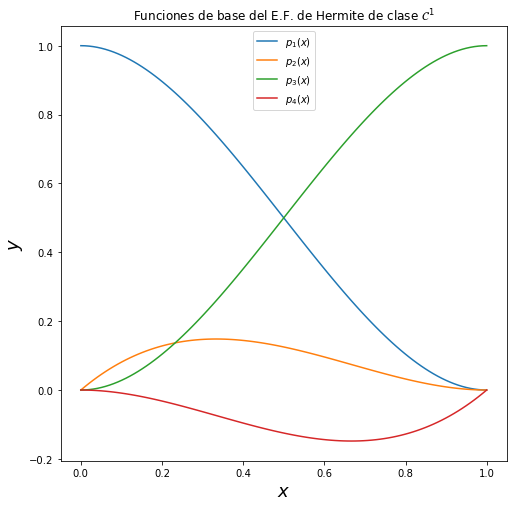

In [110]:
a = 0; b = 1; nxx = 100; # Veámos qué forma tienen sus gráficas
xx = np.linspace(a,b,nxx)
yy1 = p1(xx); yy2 = p2(xx); yy3 = p3(xx); yy4 = p4(xx)
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(xx,yy1,label='$p_1(x)$')
ax.plot(xx,yy2,label='$p_2(x)$')
ax.plot(xx,yy3,label='$p_3(x)$')
ax.plot(xx,yy4,label='$p_4(x)$')
ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Funciones de base del E.F. de Hermite de clase $\mathcal{C}^1$');

Vemos pues claramente que cada uno de estos polinomios 'controla' perfectamente uno y sólo uno de los datos considerados en el intervalo $[0,1]$; es decir, cada uno de ellos toma el  valor $0$ en todos los datos considerados $\{p(0),p'(0),p(1),p'(1)\}$ salvo en uno de ellos en los que toma el valor $1$. Así pues juegan exactamente el mismo papel que la base de Lagrange para la interpolación con datos lagrangianos que vimos al principio de esta práctica. Por lo tanto, a partir de esta base, podríamos expresar sin demasiado esfuerzo el correspondiente polinomio $p(x)$ de grado menor o igual a $3$ que satisface dichos datos de interpolación, bastaría con usar la siguiente fórmula

$$p(x) = p(0)p_1(x)+p'(0)p_2(x)+p(1)p_3(x)+p'(1)p_4(x)$$

**Cuestión** La pregunta que surge ahora sería la siguiente: ¿Y si nuestros datos de interpolación de Hermite estuvieran dados en un intervalo genérico $[x_L,x_R]$ en vez de en el $[0,1]$?

**Respuesta** Vamos a ver entonces, que bastaría con considerar adecuadamente la transformación afín que lleva dicho intervalo $F:[x_L,x_R]\longrightarrow [0,1]$  $$F(z):=\frac{x-x_L}{x_R-x_L}$$ cuya derivada es simplemente $\frac{1}{x_R-x_L}$ y habrá que tener en cuenta también a la hora de ajustar los coeficientes de la nueva base en el intervalo $[x_L,x_R]$.

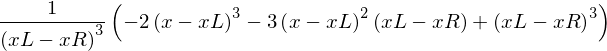

In [111]:
p1((x-xL)/(xR-xL)).simplify()

In [112]:
def p1xLxR(x,xL,xR):
    return 1/(xL-xR)**3*(-2*(x-xL)**3-3*(x-xL)**2*(xL-xR)+(xL-xR)**3)

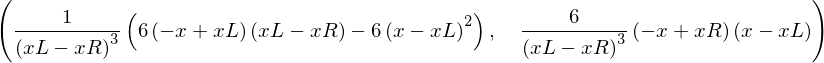

In [115]:
sp.diff(p1((x-xL)/(xR-xL)),x).simplify(),sp.diff(p1xLxR(x,xL,xR),x).simplify()

In [116]:
p1xLxR(x,xL,xR).subs({x:xL}),p1xLxR(x,xL,xR).subs({x:xR}).simplify()

In [118]:
sp.diff(p1xLxR(x,xL,xR),x).subs({x:xL}),sp.diff(p1xLxR(x,xL,xR),x).subs({x:xR}).simplify()

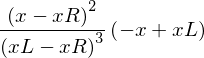

In [119]:
p2((x-xL)/(xR-xL)).simplify()

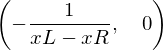

In [120]:
# Véamos que pasa ahora cuando intentamos hacer lo mismo con p2(x)
sp.diff(p2((x-xL)/(xR-xL)),x).subs({x:xL}).simplify(),sp.diff(p2((x-xL)/(xR-xL)),x).subs({x:xR}).simplify()

In [121]:
# Así pues, para que todo cuadre de nuevo tendremos que tener en
def p2xLxR(x,xL,xR): # cuenta este factor multiplicativo 
    return (x-xR)**2/(xL-xR)**3*(-x+xL)*(xR-xL) # en la definición.

In [122]:
sp.diff(p2xLxR(x,xL,xR),x).subs({x:xL}).simplify(),sp.diff(p2xLxR(x,xL,xR),x).subs({x:xR}).simplify()

De manera totalmente análoga definiríamos las correspondientes funciones de base genéricas `p3xLxR(x)` y `p4xLxR(x)`.

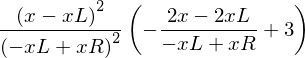

In [123]:
p3((x-xL)/(xR-xL))

In [124]:
def p3xLxR(x,xL,xR):
    return (x-xL)**2/(-xL+xR)**2*(-(2*x-2*xL)/(-xL+xR)+3)

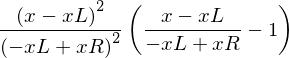

In [125]:
p4((x-xL)/(xR-xL))

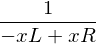

In [126]:
sp.diff(p4((x-xL)/(xR-xL)),x).subs({x:xR})

In [127]:
def p4xLxR(x,xL,xR):
    return (x-xL)**2/(-xL+xR)**2*((x-xL)/(-xL+xR)-1)*(xR-xL)

In [128]:
p = yL*p1xLxR(x,xL,xR)+dL*p2xLxR(x,xL,xR)+yR*p3xLxR(x,xL,xR)+dR*p4xLxR(x,xL,xR)

In [129]:
p.subs({x:xL}),p.subs({x:xR}).simplify()

In [130]:
sp.diff(p,x).subs({x:xL}).simplify(),sp.diff(p,x).subs({x:xR}).simplify()

### Quíntica que pasa por dos puntos, especificando también la pendiente, así como la derivada segunda en ellos

In [131]:
x = sp.Symbol('x')
xL,yL,dL,d2L,xR,yR,dR,d2R = sp.symbols('xL,yL,dL,d2L,xR,yR,dR,d2R')

In [132]:
x,xL,yL,dL,d2L,xR,yR,dR,d2R

In [133]:
cubicaconderivadas(x,0,1,0,1,0,0)

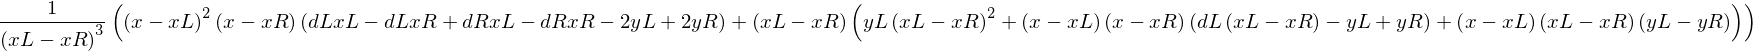

In [134]:
p3 = cubicaconderivadas(x,xL,yL,dL,xR,yR,dR).simplify()
p3

In [135]:
p3 = cubicaconderivadas(x,xL,yL,dL,xR,yR,dR).simplify()
D1,D2 = sp.symbols('D1,D2')
p5 = p3 + D1*(x-xL)**2*(x-xR)**2+D2*(x-xL)**3*(x-xR)**2 
d2p5 = sp.diff(p5,x,2).simplify()
ecL = d2p5.subs({x:xL}).simplify()-d2L
ecR = d2p5.subs({x:xR}).simplify()-d2R
sol5 = sp.solve([ecL,ecR],[D1,D2])

In [136]:
D1 = D1.subs(sol5).simplify()
print(D1)

(d2L*xL**2/2 - d2L*xL*xR + d2L*xR**2/2 - 2*dL*xL + 2*dL*xR - dR*xL + dR*xR + 3*yL - 3*yR)/(xL**4 - 4*xL**3*xR + 6*xL**2*xR**2 - 4*xL*xR**3 + xR**4)


In [137]:
D2 = D2.subs(sol5).simplify()
print(D2)

(d2L*xL**2 - 2*d2L*xL*xR + d2L*xR**2 - d2R*xL**2 + 2*d2R*xL*xR - d2R*xR**2 - 6*dL*xL + 6*dL*xR - 6*dR*xL + 6*dR*xR + 12*yL - 12*yR)/(2*(xL**5 - 5*xL**4*xR + 10*xL**3*xR**2 - 10*xL**2*xR**3 + 5*xL*xR**4 - xR**5))


In [138]:
p5 = p3 + D1*(x-xL)**2*(x-xR)**2+D2*(x-xL)**3*(x-xR)**2

In [139]:
def quintica(x,xL,yL,dL,d2L,xR,yR,dR,d2R):
    """quíntica con datos de Lagrange y Hermite en ambos extremos"""
    D1 = (d2L*xL**2/2 - d2L*xL*xR + d2L*xR**2/2 - 2*dL*xL + 2*dL*xR - dR*xL + dR*xR + 3*yL - 3*yR)/(xL**4 - 4*xL**3*xR + 6*xL**2*xR**2 - 4*xL*xR**3 + xR**4)
    D2 = (d2L*xL**2 - 2*d2L*xL*xR + d2L*xR**2 - d2R*xL**2 + 2*d2R*xL*xR - d2R*xR**2 - 6*dL*xL + 6*dL*xR - 6*dR*xL + 6*dR*xR + 12*yL - 12*yR)/(2*(xL**5 - 5*xL**4*xR + 10*xL**3*xR**2 - 10*xL**2*xR**3 + 5*xL*xR**4 - xR**5))
    return cubicaconderivadas(x,xL,yL,dL,xR,yR,dR) + D1*(x-xL)**2*(x-xR)**2+D2*(x-xL)**3*(x-xR)**2

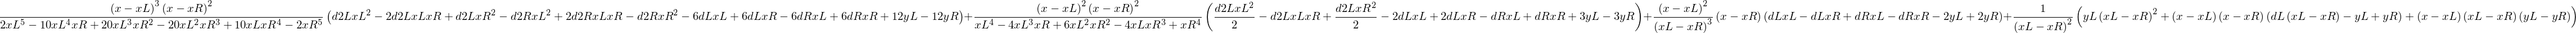

In [140]:
quintica(x,xL,yL,dL,d2L,xR,yR,dR,d2R).simplify()

In [141]:
quintica(x,0,1,0,0,1,0,0,0).expand()

In [142]:
quintica(x,0,0,1,0,1,0,0,0).expand()

In [143]:
quintica(xL,xL,yL,dL,d2L,xR,yR,dR,d2R).simplify()

In [144]:
quintica(xR,xL,yL,dL,d2L,xR,yR,dR,d2R).simplify()

In [146]:
sp.diff(quintica(x,xL,yL,dL,d2L,xR,yR,dR,d2R),x).subs({x:xL}).simplify()

In [149]:
sp.diff(quintica(x,xL,yL,dL,d2L,xR,yR,dR,d2R),x).subs({x:xR}).simplify()

In [150]:
sp.diff(quintica(x,xL,yL,dL,d2L,xR,yR,dR,d2R),x,2).subs({x:xL}).simplify()

In [151]:
sp.diff(quintica(x,xL,yL,dL,d2L,xR,yR,dR,d2R),x,2).subs({x:xR}).simplify()

In [152]:
p01001000 = quintica(x,0,1,0,0,1,0,0,0).simplify()
p00101000 = quintica(x,0,0,1,0,1,0,0,0).simplify()
p00011000 = quintica(x,0,0,0,1,1,0,0,0).simplify()
p00001100 = quintica(x,0,0,0,0,1,1,0,0).simplify()
p00001010 = quintica(x,0,0,0,0,1,0,1,0).simplify()
p00001001 = quintica(x,0,0,0,0,1,0,0,1).simplify()

In [153]:
print(p01001000)
print(p00101000)
print(p00011000)
print(p00001100)
print(p00001010)
print(p00001001)

-6.0*x**5 + 15.0*x**4 - 10.0*x**3 + 1.0
x*(-3.0*x**4 + 8.0*x**3 - 6.0*x**2 + 1.0)
0.5*x**2*(-x + 1)**3
x**3*(6.0*x**2 - 15.0*x + 10.0)
x**3*(-3.0*x**2 + 7.0*x - 4.0)
0.5*x**3*(x - 1)**2


In [154]:
def p1(x):
    return -6*x**5 + 15*x**4 - 10*x**3 + 1
def p2(x):
    return x*(-3*x**4 + 8*x**3 - 6*x**2 + 1)
def p3(x):
    return x**2/2*(-x + 1)**3
def p4(x):
    return x**3*(6*x**2 - 15*x + 10)
def p5(x):
    return x**3*(-3*x**2 + 7*x - 4)
def p6(x):
    return x**3*(x - 1)**2/2

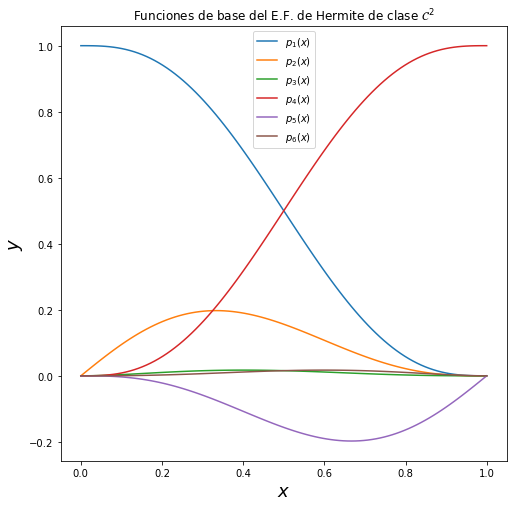

In [155]:
a = 0; b = 1; nxx = 100; # Veámos qué forma tienen sus gráficas
xx = np.linspace(a,b,nxx)
yy1 = p1(xx); yy2 = p2(xx); yy3 = p3(xx);
yy4 = p4(xx); yy5 = p5(xx); yy6 = p6(xx);
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(xx,yy1,label='$p_1(x)$')
ax.plot(xx,yy2,label='$p_2(x)$')
ax.plot(xx,yy3,label='$p_3(x)$')
ax.plot(xx,yy4,label='$p_4(x)$')
ax.plot(xx,yy5,label='$p_5(x)$')
ax.plot(xx,yy6,label='$p_6(x)$')
ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Funciones de base del E.F. de Hermite de clase $\mathcal{C}^2$');

In [156]:
print(p1((x-xL)/(xR-xL)).simplify())

(6*(x - xL)**5 + 15*(x - xL)**4*(xL - xR) + 10*(x - xL)**3*(xL - xR)**2 + (xL - xR)**5)/(xL - xR)**5


In [157]:
print((p2((x-xL)/(xR-xL))*(xR-xL)).simplify())

-(x - xL)*(3*(x - xL)**4 + 8*(x - xL)**3*(xL - xR) + 6*(x - xL)**2*(xL - xR)**2 - (xL - xR)**4)/(xL - xR)**4


In [158]:
print((p3((x-xL)/(xR-xL))*(xR-xL)**2).simplify())

(x - xL)**2*(x - xR)**3/(2*(xL - xR)**3)


In [159]:
print(p4((x-xL)/(xR-xL)).simplify())

-(x - xL)**3*(6*(x - xL)**2 + 15*(x - xL)*(xL - xR) + 10*(xL - xR)**2)/(xL - xR)**5


In [160]:
print((p5((x-xL)/(xR-xL))*(xR-xL)).simplify())

-(x - xL)**3*(3*(x - xL)**2 + 7*(x - xL)*(xL - xR) + 4*(xL - xR)**2)/(xL - xR)**4


In [161]:
print((p6((x-xL)/(xR-xL))*(xR-xL)**2).simplify())

-(x - xL)**3*(x - xR)**2/(2*(xL - xR)**3)


In [162]:
def p1C2xLxR(x,xL,xR):
    return (6*(x - xL)**5 + 15*(x - xL)**4*(xL - xR) + 10*(x - xL)**3*(xL - xR)**2 + (xL - xR)**5)/(xL - xR)**5
def p2C2xLxR(x,xL,xR):
    return -(x - xL)*(3*(x - xL)**4 + 8*(x - xL)**3*(xL - xR) + 6*(x - xL)**2*(xL - xR)**2 - (xL - xR)**4)/(xL - xR)**4
def p3C2xLxR(x,xL,xR):
    return (x - xL)**2*(x - xR)**3/(2*(xL - xR)**3)
def p4C2xLxR(x,xL,xR):
    return -(x - xL)**3*(6*(x - xL)**2 + 15*(x - xL)*(xL - xR) + 10*(xL - xR)**2)/(xL - xR)**5
def p5C2xLxR(x,xL,xR):
    return -(x - xL)**3*(3*(x - xL)**2 + 7*(x - xL)*(xL - xR) + 4*(xL - xR)**2)/(xL - xR)**4
def p6C2xLxR(x,xL,xR):
    return -(x - xL)**3*(x - xR)**2/(2*(xL - xR)**3)

In [163]:
p = yL*p1C2xLxR(x,xL,xR)+dL*p2C2xLxR(x,xL,xR)+d2L*p3C2xLxR(x,xL,xR)+yR*p4C2xLxR(x,xL,xR)+dR*p5C2xLxR(x,xL,xR)+d2R*p6C2xLxR(x,xL,xR)

In [164]:
p.subs({x:xL}),p.subs({x:xR}).simplify()

In [167]:
sp.diff(p,x).subs({x:xL}),sp.diff(p,x).subs({x:xR}).simplify()

In [168]:
sp.diff(p,x,2).subs({x:xL}),sp.diff(p,x,2).subs({x:xR}).simplify()

### La orden interpolate

In [174]:
?interpolate

In [170]:
datos = [[1, [5, 1, 0]], [3, [1, 3]], [5, -2]]

In [171]:
x = np.array([1,3,5])
xdatos = [[5,1,0],[1,3],-2]

In [177]:
datos[0]

In [178]:
datos[1]

In [179]:
datos[2]

# Interpolación polinómica lagrangiana

 Pero también dentro de la clase `Polynomial` hay un procedimiento `fit` que permite realizar el proceso de interpolación o ajuste de datos. Veámos la ayuda que proporciona Python para ver cómo se usa.

In [180]:
?P.Polynomial.fit

In [181]:
x = np.array([-1,0,1,2])
y = np.array([4,2,-3,1])

In [182]:
x.min(),x.max()

(-1, 2)

In [183]:
grado = len(x)-1  # habrá que indicar el grado correcto
pinterp = P.Polynomial.fit(x,y,grado) 
pinterp

Polynomial([-0.875, -8.25 ,  3.375,  6.75 ], [-1.,  2.], [-1.,  1.])

In [184]:
pajuste = P.Polynomial.fit(x,y,1) # nótese que al indicar un grado 
# inferior obtendremos sólo un polinomio de ajuste
pajuste

Polynomial([ 1. , -2.1], [-1.,  2.], [-1.,  1.])

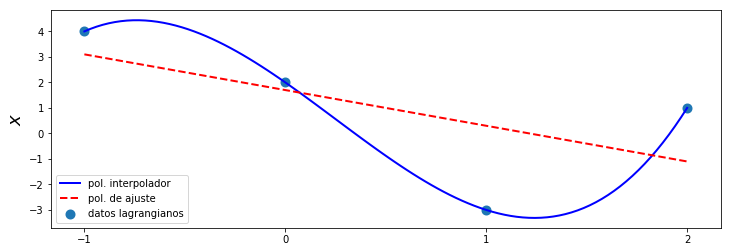

In [185]:
xx = np.linspace(x.min(),x.max(),100)
fig, ax = plt.subplots(1,1,figsize = (12,4))
ax.plot(xx,pinterp(xx),'b',lw=2,label='pol. interpolador')
ax.plot(xx,pajuste(xx),'r--',lw=2,label='pol. de ajuste')
ax.scatter(x,y,lw = 4,label='datos lagrangianos')
ax.legend(loc=3)
ax.set_xticks(x)
ax.set_ylabel(r"$y$",fontsize = 18)
ax.set_ylabel(r"$x$",fontsize = 18)
plt.show()

Si lo que queremos es obtener la correspondiente matriz de Gramm (a veces también denominada de Vandermonde, en el caso de la interpolación lagrangiana), podemos obtenerla en diferentes bases de polinomios, de manera que aunque el polinomio interpolador será el mismo (dada la univolvencia del problema) habrá casos en los que podremos mejorar enormemente el número de condición de la matriz corespondiente, con lo que la resolución numérica del problema se verá mucho menos afectado por los pequeños errores de redondeo inherentes en todo este tipo de problemas.

In [186]:
APoly = P.polynomial.polyvander(x,grado)
np.linalg.cond(APoly,np.inf),np.linalg.cond(APoly)

In [187]:
ACheb = P.chebyshev.chebvander(x,grado)
np.linalg.cond(ACheb,np.inf),np.linalg.cond(ACheb)

In [188]:
ALaguerre = P.laguerre.lagvander(x,grado)
np.linalg.cond(ALaguerre,np.inf),np.linalg.cond(ALaguerre)

In [189]:
AHermite = P.hermite.hermvander(x,grado)
np.linalg.cond(AHermite,np.inf),np.linalg.cond(AHermite)

In [190]:
cPoly = np.linalg.solve(APoly,y)
pPoly = P.Polynomial(cPoly)
pPoly(x) == y

array([False, False, False, False], dtype=bool)

In [191]:
cCheb = np.linalg.solve(ACheb,y)
pCheb = P.Chebyshev(cCheb)
pCheb(x) == y

array([False, False, False, False], dtype=bool)

In [192]:
cLaguerre = np.linalg.solve(ALaguerre,y)
pLaguerre = P.Laguerre(cLaguerre)
pLaguerre(x),y

(array([ 4.,  2., -3.,  1.]), array([ 4,  2, -3,  1]))

In [193]:
cHermite = np.linalg.solve(AHermite,y)
pHermite = P.Hermite(cHermite)
pHermite(x) == y

array([ True,  True,  True,  True], dtype=bool)

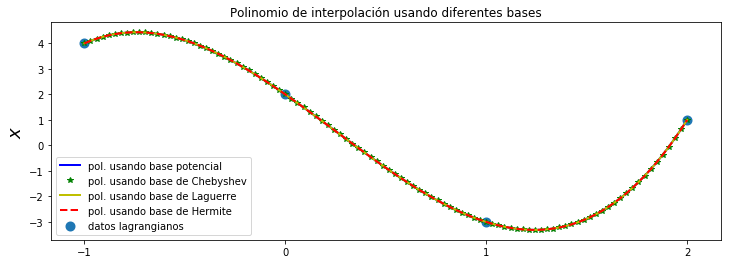

In [194]:
xx = np.linspace(x.min(),x.max(),100)
fig, ax = plt.subplots(1,1,figsize = (12,4))
ax.plot(xx,pPoly(xx),'b',lw=2,label='pol. usando base potencial')
ax.plot(xx,pCheb(xx),'g*',lw=2,label='pol. usando base de Chebyshev')
ax.plot(xx,pLaguerre(xx),'y',lw=2,label='pol. usando base de Laguerre')
ax.plot(xx,pHermite(xx),'r--',lw=2,label='pol. usando base de Hermite')
ax.scatter(x,y,lw = 4,label='datos lagrangianos')
ax.legend(loc=3)
ax.set_xticks(x)
ax.set_ylabel(r"$y$",fontsize = 18)
ax.set_ylabel(r"$x$",fontsize = 18)
ax.set_title("Polinomio de interpolación usando diferentes bases")
plt.show()

Pero hay una manera aún más directa y simple de obtener este polinomio de interpolación, o de ajuste en su caso, expresado en la base de polinomios que se indique. Para ello, cada clase de estos polinomios posee el método de clase `fit` que puede usarse para ello.

In [195]:
pPoly = P.Polynomial.fit(x,y,grado)
pPoly

Polynomial([-0.875, -8.25 ,  3.375,  6.75 ], [-1.,  2.], [-1.,  1.])

In [196]:
pCheb = P.Chebyshev.fit(x,y,grado)
pCheb

Chebyshev([ 0.8125, -3.1875,  1.6875,  1.6875], [-1.,  2.], [-1.,  1.])

In [197]:
pLaguerre = P.Laguerre.fit(x,y,grado)
pLaguerre

Laguerre([ 203.5, -712.5,  837. , -324. ], [-1.,  2.], [ 0.,  1.])

Nótese además que, aún tratándose en todos los casos del mismo polinomio de interpolación, los coeficientes están dados en cada caso en la base indicada. Por otro lado, el dominio en el que se consideran está adaptado en todos los casos al intervalo dónde se encuentran las abcisas de los puntos de interpolación, mientras que el segundo intervalo sobre el que se transforman puede ser el $[-1,1]$ o bien el $[0,1]$, según convenga, mediante las transformaciones afines $x\to 2\frac{x-a}{b-a}-1$, o $x\to \frac{x-a}{b-a}$, respectivamente.

Podemos comprobar ahora hasta qué punto puede influir, en algunos casos, la adecuada transformación del intervalo de partida en un intervalo adecuado a la base de polinomios con el que estemos trabajando.

In [198]:
x = np.array([1,2,3,4]) # valores nuevos
y = np.array([1,3,5,4])

a = x.min(); b = x.max()
grado = len(x)-1

In [199]:
A = P.polynomial.polyvander(x,grado)
c = np.linalg.solve(A,y)
c

array([ 2. , -3.5,  3. , -0.5])

In [200]:
p = P.Polynomial(c)
p

Polynomial([ 2. , -3.5,  3. , -0.5], [-1,  1], [-1,  1])

In [201]:
ACheb = P.chebyshev.chebvander(x,grado)
cCheb = np.linalg.solve(ACheb,y)
cCheb

array([ 3.5  , -3.875,  1.5  , -0.125])

In [202]:
pCheb = P.Chebyshev(cCheb)
pCheb

Chebyshev([ 3.5  , -3.875,  1.5  , -0.125], [-1,  1], [-1,  1])

In [203]:
pChebbis = P.Chebyshev.fit(x,y,grado)
pChebbis

Chebyshev([ 3.34375 ,  1.921875, -0.84375 , -0.421875], [ 1.,  4.], [-1.,  1.])

In [204]:
np.linalg.cond(P.chebyshev.chebvander(x,grado))

In [205]:
np.linalg.cond(P.chebyshev.chebvander(2*(x-a)/(b-a)-1,grado))

## Fórmulas de Lagrange y Newton para la interpolación polinómica lagrangiana

Vamos a obtener y comparar la fórmulas de Lagrange y la de Newton para la interpolación polinómica lagrangiana. Los nodos de interpolación van a ser $0, 1, 2,\ldots, 10$, y los guardaremos en una lista `x`. Los valores a interpolar serán números aleatorios comprendidos entre $0$ y $8$, que guardamos en un vector $y$. Se generan a partir de la orden `random()`.

In [206]:
n = 4
xdatos = [i for i in range(n+1)]
ydatos = [8*np.random.random() for i in range(n+1)]
y = ydatos.copy()

A partir de estos valores, el polinomio de interpolación se puede calcular directamente, a partir de las conocidas fórmulas de la base de Lagrange

### Fórmula de Lagrange

In [207]:
t = sp.Symbol('t')

In [208]:
x = xdatos.copy() # hacemos una copia de las abcisas
def pi(i,t):      # y definimos la base de Lagrange correspondiente
    return np.product([(t-x[j])/(x[i]-x[j]) for j in range(i)])*np.product([(t-x[j])/(x[i]-x[j]) for j in range(i+1,n+1)])

In [209]:
def p(t): # fórmula de Lagrange del polinomio de interpolación
    return sum([y[i]*pi(i,t) for i in range(n+1)])
p_vec = np.vectorize(p) # junto con su versión vectorizada

In [210]:
l=0;  # podríamos ir cambiando el índice 'l' 
p(x[l]) == y[l]  # para comprobar todos los datos

True

In [211]:
p_vec(x) == y # comprobación de que la interpolación de Lagrange ha
# sido realizada correctamente en los puntos inicialmente indicados

array([ True,  True,  True,  True,  True], dtype=bool)

In [212]:
p_vec(x)

array([ 2.85346772,  4.41172611,  7.51845728,  1.94788073,  5.62810485])

In [213]:
?p_vec

In [214]:
print(p(x[0]))

2.85346772066


In [215]:
p_vec(x)

array([ 2.85346772,  4.41172611,  7.51845728,  1.94788073,  5.62810485])

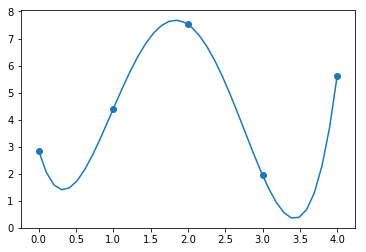

In [216]:
xx = np.linspace(x[0],x[n],10*n)  # realicemos ahora
yy = p_vec(xx)                    # un gráfico
plt.plot(xx,yy)     # del polinomio de interpolación
plt.scatter(x,y);   # así como de los puntos de partida 
# Nótense las excesivas oscilaciones en alguno de los casos.

### Fórmula de Newton

Ahora vamos a obtener este mismo polinomio usando la denominada **fórmula de Newton**, que usa las llamadas *diferencias divididas*, que introduciremos más abajo. La idea de la fórmula de Newton consiste en ir obteniendo de manera sistemática polinomios de grado creciente, que vayan incorporando cada vez un dato lagrangiano más.
Así pues, si tenemos los datos de interpolación lagrangianos de costumbre $(x_0,f(x_0)\equiv y_0),(x_1,f(x_1)\equiv y_1),\ldots,(x_{n-1},f(x_{n-1})\equiv y_{n-1}),(x_n,f(x_n)\equiv y_n)$, con $x_0=a$, $x_n=b$ y $x_i\in]a,b[$ con $x_i\neq x_j, \forall i\neq j\in\{0,1,\ldots,n\}$, empezaríamos con el correspondiente polinomio de grado $0$ (constante) que interpola sólo el primer dato $p_0(x)=y_0=f(x_0)\equiv f[x_0]$ e iremos añadiendo un dato nuevo distinto cada vez, de la siguiente manera 
$p_1(x)=p_0(x)+(x-x_0)f[x_0,x_1]$, donde $f[x_0,x_1]$ denotará la denominada *diferencia dividida* de la función asociada a los nodos $x_0,x_1$ y cuyo expresión general puede obtenerse sin más que imponer la nueva condición de interpolación 
$$y_1=f(x_1)=p_1(x_1)=p_0(x_1)+(x_1-x_0)f[x_0,x_1]$$ y despejarlo
$$ f[x_0,x_1] = \frac{f(x_1)-f(x_0)}{x_1-x_0}.$$

Así seguiríamos aplicando el mismo procedimiento, de manera recursiva, hasta llegar al polinomio de interpolación solicitado, 

$$p_n(x)=p_{n-1}(x)+(x-x_0)(x-x_1)\cdots(x-x_{n-1})f[x_0,x_1,\ldots,x_n]$$

imponiendo la última condición de interpolación $p_n(x_n)=f(x_n)=y_n$ y despejando la última diferencia dividida $f[x_0,x_1,\ldots,x_n]$, asociada a todos los nodos $x_0,x_1,\ldots,x_n$.

No obstante, más abajo veremos otra manera más automatizada de calcular estas y otras diferencias divididas a partir de una tabla estructurada.

In [217]:
x  = sp.Symbol('x')
f  = sp.Symbol('f')
x0 = sp.symbols('x0')
p0 = f(x0) # D0 = f(x0) = f[x0] será la primera diferencia dividida 

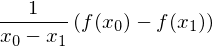

In [218]:
x1 = sp.symbols('x1')
D1 = sp.Symbol('D1') # D1 será otra diferencia dividida asociada a  
p1 = p0 + (x-x0)*D1  # los nodos de interpolación x0 y x1
sol1 = sp.solve(p1.subs({x:x1})-f(x1),D1) # se notará f[x0,x1]
sol1[0]

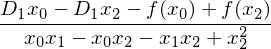

In [219]:
x2 = sp.symbols('x2')
D2 = sp.Symbol('D2') # D2 será otra diferencia dividida asociada a  
p2 = p1 + (x-x0)*(x-x1)*D2  # los nodos de interpolación x0, x1 y x2
sol2 = sp.solve(p2.subs({x:x2})-f(x2),D2) # se notará f[x0,x1,x2]
sol2[0]

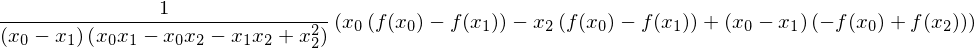

In [220]:
sol2[0].subs({D1:sol1[0]}).simplify()

Podríamos seguir así, pero vemos la necesidad de calcular de una manera más sistemática estas *diferencias divididas*, que también podemos notar $\nabla^{k}y_i,$ con $k,i \in \{0,1,\ldots, n \}$, 
a partir de la siguiente tabla de valores: 

$\nabla^{0} y_i := y_i\equiv f[x_i], \; i = 0,1,\ldots n$

$\nabla y_i\equiv \nabla^{1} y_i:= \frac{y_i-y_0}{x_i-x_0}\equiv f[x_0,x_i], \; i = 1,\ldots n$

$\nabla^{2} y_i:= \frac{\nabla y_i-\nabla y_1}{x_i-x_1}, \; i = 2,\ldots n$

$\vdots$

$\nabla^{n} y_n:= \frac{\nabla^{n-1} y_n-\nabla^{n-1} y_{n-1}}{x_n-x_{n-1}}$

In [221]:
xdatos

In [222]:
a = ydatos.copy()  
x = xdatos.copy() 
m = len(a)
n = m-1
(n,m)

In [223]:
for k in range(1,m):     # veremos cómo programar su cálculo
    for i in range(k,m): # en un solo array almacenando finalmente
        a[i] = (a[i]-a[k-1])/(x[i]-x[k-1])
a   # sólo los que realmente se necesitan para la fórmula de Newton

In [224]:
x = sp.Symbol('x')

In [225]:
p = a[n]
for k in range(n+1):
    p = a[n-k]+(x-xdatos[n-k])*p
print(p)

x*((x - 1)*((x - 2)*((x - 3)*(1.1730787030133*x - 3.51923610903991) - 1.70429674982655) + 0.774236392786363) + 1.55825838449157) + 2.8534677206614


In [226]:
xdatos

In [227]:
k=4
p.subs({x:xdatos[k]}),ydatos[k]

In [228]:
sp.expand(p)

In [229]:
pfunc = lambda z: p.subs({x:z})
pvec = np.vectorize(pfunc)

In [230]:
pfunc(0)

In [231]:
l=3  # podemos ahora ir variando este índice para ir comprobando
pfunc(xdatos[l]) - ydatos[l]  # uno a uno los datos interpolados

In [232]:
pvec(xdatos)-ydatos  # o todos a la vez usando la versión vectorizada

array([0, 0, 0, 8.88178419700125e-16, -2.66453525910038e-15], dtype=object)

In [233]:
chop_vec(pvec(xdatos)-ydatos)

array([0, 0, 0, 0, 0])

In [234]:
# t1 = time.clock()
pvec(xdatos)
# t2 = time.clock()
# t2 - t1

array([2.85346772066140, 4.41172610515297, 7.51845727521726,
       1.94788073189497, 5.62810484854604], dtype=object)

### Método de Neville

In [235]:
y = ydatos.copy()
for k in range(1,m):
    for i in range(m-k):
        y[i]=((x-xdatos[i+k]*y[i])+(xdatos[i]-x)*y[i+1])/(xdatos[i]-xdatos[i+k])

### Comportamiento asintótico de la interpolación polinómica. Ejemplo de Runge

¿Pero qué ocurre ahora cuando se aumenta el número de nodos de interpolación? Supongamos que en el intervalo $[-5,5]$ elegimos nodos uniformemente distribuidos en un número creciente y que interpolamos la función $f(x)=\frac{1}{x^2+1}$ en esos nodos. Vamos a medir la distancia entre esta función y su polinomio de interpolación en el punto medio de los dos primeros nodos. Haremos uso de la expresión de Newton dado su  menor coste computacional.

Comenzaremos indicando el procedimiento que debe seguirse para representar el polinomio de interpolación de grado menor o igual que $10$, por ejemplo, y luego calculamos los valores en el punto medio de los dos primeros nodos de los errores de interpolación asociados a los polinomos de grados $10, 20,\ldots , 80$, a fin de apreciar el comportamiento.

In [236]:
def fRunge(x):   # primero definimos la función con la que vamos
    """función 1/(x**2+1) """
    return 1/(x**2+1)   # a efectuar los cálculos en este caso
fRunge_vec = np.vectorize(fRunge) # y la vectorizamos de la manera habitual

Y formamos las listas de nodos (uniformemente espaciados en $[-5,5]$) y de valores de $f(z)$ que deben ser interpolados. En ellos calculamos las diferencias divididas y formamos el polinomio de interpolación.

In [237]:
a = -5; b = 5

In [238]:
n = 10;
x = [a + i*(b-a)/n for i in range(n+1)]

In [239]:
fRunge_vec(x)

array([ 0.03846154,  0.05882353,  0.1       ,  0.2       ,  0.5       ,
        1.        ,  0.5       ,  0.2       ,  0.1       ,  0.05882353,
        0.03846154])

In [240]:
def ejemplo_Runge(n):
    x = [a + i*(b-a)/n for i in range(n+1)]
    p = P.Polynomial.fit(x,fRunge_vec(x),n)
    return x,p

In [241]:
ejemplo_Runge(2)

([-5.0, 0.0, 5.0],
 Polynomial([  1.00000000e+00,  -5.64951819e-17,  -9.61538462e-01], [-5.,  5.], [-1.,  1.]))

In [242]:
x

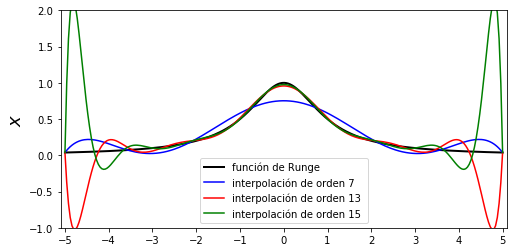

In [243]:
xx = np.linspace(a,b,250)
fig,ax = plt.subplots(1,1,figsize = (8,4))
ax.plot(xx,fRunge_vec(xx),'k',lw=2,label='función de Runge')
# ax.plot(x,f_vec(x),'ro') # parecido a scatterplot

# interpolaciones de distinto orden de la función
n = 7; x,p = ejemplo_Runge(n)
ax.plot(xx,p(xx),'b',label='interpolación de orden %d ' %n)
n = 13; x,p = ejemplo_Runge(n)
ax.plot(xx,p(xx),'r',label='interpolación de orden %d ' %n)
n = 15; x,p = ejemplo_Runge(n)
ax.plot(xx,p(xx),'g',label='interpolación de orden %d ' %n)
ax.legend(loc=8)
ax.set_xlim(-5.1,5.1)
ax.set_ylim(-1.,2.)
ax.set_xticks(range(a,b+1))
ax.set_ylabel('$y$',fontsize=18)
ax.set_ylabel('$x$',fontsize=18);

#### Nodos de Chebyshev

En el error de la interpolación polinómica lagrangiana para una función suficientemente suave intervienen dos elementos: de un lado, la norma del máximo de una cierta derivada de la función, y la norma del polinomio obtenido al multiplicar los binomios $t-x[i]$ y dividir por el factorial adecuado, del otro. Ésta última se minimiza cuando los nodos de interpolación son los ceros del correspondiente polinomio ortogonal de Chebyshev. Los ceros de los polinomios de Chebyshev de grado mayor o igual que cero, tomados como nodos de interpolación, permiten construir polinomios de interpolación de grado creciente. La continuidad de la primera derivada de la función interpolada garantiza la convergencia a cero del error de interpolación. Sin embargo, la continuidad no es, en general, suficiente.

Generemos, por ejemplo, los $11$ ceros del polinomio de Chebyshev de grado $11$ correspondientes al intervalo $[-5,5]$.

In [244]:
a,b

In [245]:
m = 11;
xChebyshev = np.array([(a+b)/2 + 1/2*(a-b)*np.cos(((2*i-1)*np.pi)/(2*m)) for i in range(1,m+1)])

In [246]:
xChebyshev[0],xChebyshev[-1]

In [247]:
a = xChebyshev.min()
b = xChebyshev.max()

In [248]:
y = fRunge_vec(xChebyshev)
y

array([ 0.03922544,  0.04611321,  0.06544959,  0.12037588,  0.33508349,
        1.        ,  0.33508349,  0.12037588,  0.06544959,  0.04611321,
        0.03922544])

In [249]:
t = sp.Symbol('t')
x = xChebyshev.copy() # hacemos una copia de las abcisas
n = len(x)-1
def pi(i,t):      # y definimos la base de Lagrange correspondiente
    return np.product([(t-x[j])/(x[i]-x[j]) for j in range(i)])*np.product([(t-x[j])/(x[i]-x[j]) for j in range(i+1,n+1)])

In [250]:
def p(t): # fórmula de Lagrange del polinomio de interpolación
    return sum([y[i]*pi(i,t) for i in range(n+1)])
p_vec = np.vectorize(p) # junto con su versión vectorizada

In [251]:
p(a),p(b)

In [252]:
p_vec(xChebyshev) == y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True], dtype=bool)

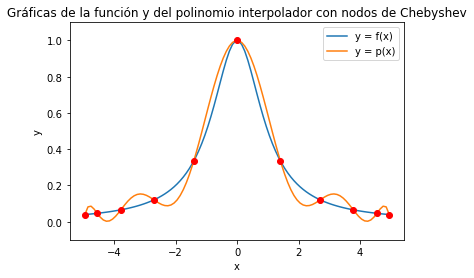

In [253]:
xx = np.linspace(x[0],x[n],10*n)  # realicemos ahora
yy = p_vec(xx)                    # un gráfico

fig, ax = plt.subplots()
ax.plot(xx,fRunge_vec(xx), label = "y = f(x)"); # gráfica de la función
ax.plot(xx, yy, label = "y = p(x)"); # polinomio de interpolación 
ax.plot(x,y,'ro') # parecido a scatterplot
ax.legend();
# ax.set_xlim(-5.1,5.1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Gráficas de la función y del polinomio interpolador con nodos de Chebyshev');

# Interpolación polinómica de Taylor

In [254]:
from math import factorial
?factorial

In [255]:
factorial(0),factorial(5)

In [256]:
x = sp.Symbol('x')
def f(x):
    """exp(x)/(6*x**2+5)"""
    return sp.exp(x)/(6*x**2+5)
f_vec = np.vectorize(f)

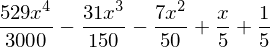

In [257]:
n = 5; x0 = 0
sum([sp.diff(f(x),x,k).subs({x:x0})*(x-x0)**k/factorial(k) for k in range(n)])

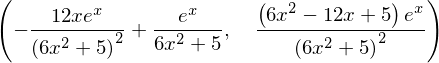

In [258]:
sp.diff(f(x),x),sp.simplify(sp.diff(f(x),x))

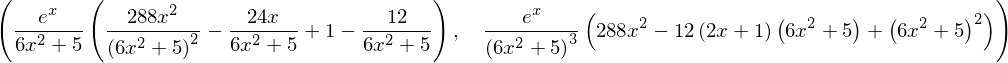

In [259]:
sp.diff(f(x),x,2),sp.simplify(sp.diff(f(x),x,2))

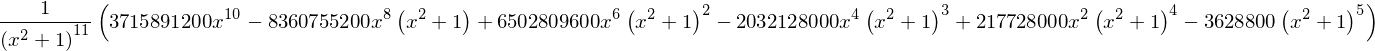

In [260]:
sp.diff(fRunge(x),x,10).simplify()

In [261]:
?f

In [262]:
from sympy import series

In [ ]:
?series

In [ ]:
?f

In [263]:
x = sp.Symbol('x')

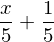

In [264]:
p2 = series(f(x),x,0, n=2).removeO()
p2

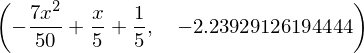

In [265]:
p3 = series(f(x),x,0, n=3).removeO()
p3,p3.subs({x:b})

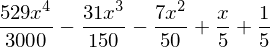

In [266]:
p5 = series(f(x),x,0, n=5).removeO()
p5

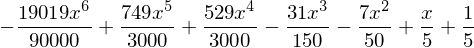

In [267]:
p7 = series(f(x),x,0, n=7).removeO()
p7

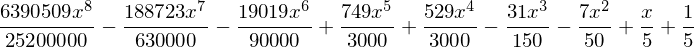

In [268]:
p9 = series(f(x),x,0, n=9).removeO()
p9

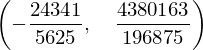

In [269]:
p7.subs({x:2}),p9.subs({x:2})

In [270]:
f(2)

In [271]:
xx = []; yy = []
y2 = []; y3 = []; y5 = []; y7 = []; y9 = []
x0 = 0; delta = 0.5;
nxx = 100; a = x0 -delta; b = x0 + delta
for i in range(nxx+1):
    xaux = a + i*(b-a)/nxx
    xx.append(xaux)
    yy.append(f(xaux))
    y2.append(p2.subs({x:xaux}))
    y3.append(p3.subs({x:xaux}))
    y5.append(p5.subs({x:xaux}))
    y7.append(p7.subs({x:xaux}))
    y9.append(p9.subs({x:xaux}))

In [272]:
len(xx),len(yy),len(y9)

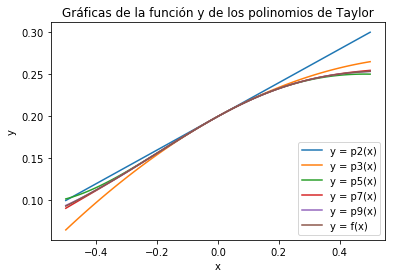

In [273]:
fig, ax = plt.subplots() # Dibujaremos los polinomios de Taylor
ax.plot(xx, y2, label = "y = p2(x)"); #  de orden 1 
ax.plot(xx, y3, label = "y = p3(x)"); #  de orden 3 
ax.plot(xx, y5, label = "y = p5(x)"); #  de orden 5
ax.plot(xx, y7, label = "y = p7(x)"); #  de orden 7
ax.plot(xx, y9, label = "y = p9(x)"); #  de orden 9
ax.plot(xx,f_vec(xx), label = "y = f(x)"); # y la función f(x)
ax.legend(loc=4);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Gráficas de la función y de los polinomios de Taylor');

# Interpolación polinómica de Hermite clásica

La interpolación de Hermite clásica consiste en que se satisfagan también datos de la derivada primera, aparte de los datos lagrangianos habituales, en los extremos del intervalo considerado; es decir, por ejemplo, en un intervalo $[a,b]$ de la recta real impondríamos que el polinomio de interpolación $p(x)$, que ahora tendría que ser de grado $3$, satisfaría las cuatro condiciones siguientes:
$$p(a)=f(a),\; p(b)=f(b),\; p'(a)=f'(a),\; p'(b)=f'(b)$$

Una forma pues de obtener dicho polinomio de interpolación de Hermite sería imponer sin más estas cuatro condiciones a un polinomio genérico de grado $3$, 
$$p(x)\equiv c_0+c_1 x+c_2 x^2 + c_3 x^3$$
y resolver el sistema lineal de orden $4$ correspondiente. 

Otra forma algo más sútil sería expresar dicho polinomio en una base más conveniente, distinta de la canónica; por ejemplo 
$p(x)\equiv d_0+d_1(x-a)+d_2(x-a)^2+d_3(x-a)^2(x-b)$ y obtener dichos coeficientes fácilmente a partir de las condiciones impuestas. Esto se podría hacer sin demasiada dificultad con la ayuda de las capacidades de cálculo simbólico de Python, via el módulo SymPy. Pero recordamos que un poco más arriba ya hemos calculado de manera genérica, la base de Hermite que permite calcular la cúbica que pasa por dos puntos determinados del plano sobre los que también hemos fijado las pendientes (o derivadas). Y esto lo hicimos trasladando al intervalor $[0,1]$ cualquier otro intervalo $[x_L,x_R]$ y ajustando con los factores convenientes la correspondiente base en el intervalo de referencia. Más adelante, veremos que esta es la idea fundamental del denominado **Método de los Elementos Finitos** y que este no es más que un caso particular, llamado **Elemento Finito de Hermite de clase $\mathcal{C}^1$**, que a su vez no es más que un caso particular de los llamados **splines cúbicos de clase $\mathcal{C}^1$**. 

Sin demasiado esfuerzo teórico, también podríamos ver que, usando el mismo tipo de ideas, también podríamos obtener polinomios de grado no superior a $5$ que satisfagan también datos de derivadas segundas en los extremos del intervalo, 

$$p(a)=f(a),\; p(b)=f(b),\; p'(a)=f'(a), p'(b)=f'(b)\\ p''(a)=f''(a),\; p''(b)=f''(b)$$

dando lugar posteriormente a los denominados **splines quínticos de clase $\mathcal{C}^2$** o el correspondiente **Elemento Finito de Hermite de clase $\mathcal{C}^2$**.

In [274]:
f   = sp.Symbol('f')
df  = sp.Symbol('df')
d2f = sp.Symbol('d2f')

In [275]:
a,b = sp.symbols('a,b')

In [276]:
x = sp.Symbol('x')

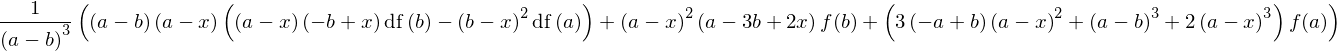

In [277]:
p = f(a)*p1xLxR(x,a,b)+df(a)*p2xLxR(x,a,b)+f(b)*p3xLxR(x,a,b)+df(b)*p4xLxR(x,a,b)
p.simplify()

In [278]:
p.subs({x:a}),p.subs({x:b}).simplify()

In [282]:
sp.diff(p,x).subs({x:a}).simplify(),sp.diff(p,x).subs({x:b}).simplify()

Ahora podemos definir un procedimiento o función que nos proporcione el correspondiente polinomio de interpolación de Hermite, a partir de los datos necesarios en el intervalo $[a,b]$; es decir, $f(a),f(b),f'(a),f'(b)$.

In [283]:
def polHermiteC1(a,b,x,fa,fb,dfa,dfb):
    """polinomio de interpolación de Hermite"""
    return fa*p1xLxR(x,a,b)+dfa*p2xLxR(x,a,b)+fb*p3xLxR(x,a,b)+dfb*p4xLxR(x,a,b)

In [287]:
polHermiteC1(a,b,x,f(a),f(b),df(a),df(b)).subs({x:a}).simplify()

In [288]:
polHermiteC1(a,b,x,f(a),f(b),df(a),df(b)).subs({x:b}).simplify()

In [289]:
sp.diff(polHermiteC1(a,b,x,f(a),f(b),df(a),df(b)),x).subs({x:a}).simplify()

In [291]:
sp.diff(polHermiteC1(a,b,x,f(a),f(b),df(a),df(b)),x).subs({x:b}).simplify()

In [ ]:
polHermiteC1(x,a,b,f(a),f(b),df(a),df(b)).simplify()

Obtenemos finalmente, terminando de factorizar alguna de las expresiones, que
$$p(x)\equiv f(a) + (x-a)f'(a) + (x-a)^2\left(
\frac{f(b)-f(a)}{(b-a)^2}-\frac{f'(a)}{b-a}\right)+(x-a)^3\left(
\frac{f'(b)+f'(a)}{(b-a)^2}-2\frac{f(b)-f(a)}{(b-a)^3}
\right)$$

Y lo mismo podríamos hacer en el caso de la interpolación de Hermite con derivadas hasta segundo orden, tal y cómo lo desarrollamos un poco más arriba en esta práctica, con los correspondientes polinomios de grado no superior a $5$.

In [292]:
def polHermiteC2(a,b,x,fa,fb,dfa,dfb,d2fa,d2fb):
    """polinomio de interpolación de Hermite"""
    return fa*p1C2xLxR(x,a,b)+dfa*p2C2xLxR(x,a,b)+d2fa*p3C2xLxR(x,a,b)+fb*p4C2xLxR(x,a,b)+dfb*p5C2xLxR(x,a,b)+d2fb*p6C2xLxR(x,a,b)

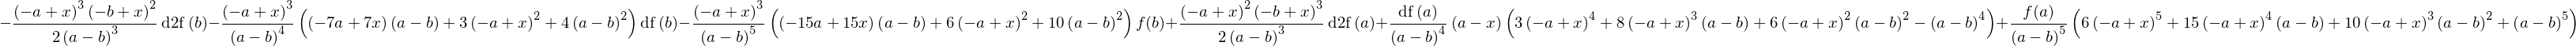

In [293]:
polHermiteC2(a,b,x,f(a),f(b),df(a),df(b),d2f(a),d2f(b))

In [294]:
polHermiteC2(a,b,x,f(a),f(b),df(a),df(b),d2f(a),d2f(b)).subs({x:a})

In [295]:
polHermiteC2(a,b,x,f(a),f(b),df(a),df(b),d2f(a),d2f(b)).subs({x:b}).simplify()

In [296]:
sp.diff(polHermiteC2(a,b,x,f(a),f(b),df(a),df(b),d2f(a),d2f(b)),x).subs({x:a}).simplify()

In [297]:
sp.diff(polHermiteC2(a,b,x,f(a),f(b),df(a),df(b),d2f(a),d2f(b)),x).subs({x:b}).simplify()

In [298]:
sp.diff(polHermiteC2(a,b,x,f(a),f(b),df(a),df(b),d2f(a),d2f(b)),x,2).subs({x:a}).simplify()

In [299]:
sp.diff(polHermiteC2(a,b,x,f(a),f(b),df(a),df(b),d2f(a),d2f(b)),x,2).subs({x:b}).simplify()

Haremos a continuación un ejemplo concreto de interpolación de Hermite clásica, a partir de los valores de una cierta función en los extremos del intervalo considerado. 

In [300]:
x = sp.Symbol('x')
def f(x):
    """sin(x)"""
    return sp.sin(x)
f_vec = np.vectorize(f)

In [301]:
print(sp.diff(f(x),x).simplify())

cos(x)


In [302]:
def df(x):
    return sp.cos(x)

In [303]:
print(sp.diff(f(x),x,2).simplify())

-sin(x)


In [304]:
def d2f(x):
    return -sp.sin(x)

In [305]:
a,b = -sp.pi,sp.pi

In [306]:
f(a),f(b),df(a),df(b),d2f(a),d2f(b)

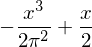

In [307]:
p3HermiteC1 = polHermiteC1(a,b,x,f(a),f(b),df(a),df(b))
p3HermiteC1.expand()

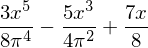

In [308]:
p5HermiteC2 = polHermiteC2(a,b,x,f(a),f(b),df(a),df(b),d2f(a),d2f(b))
p5HermiteC2.expand()

In [309]:
xx = []; yy = []
yHermiteC1 = []; yHermiteC2 = []
nxx = 100
for i in range(nxx+1):
    xaux = a + i*(b-a)/nxx
    xx.append(xaux)
    yy.append(f(xaux))
    yHermiteC1.append(p3HermiteC1.subs({x:xaux}))
    yHermiteC2.append(p5HermiteC2.subs({x:xaux}))

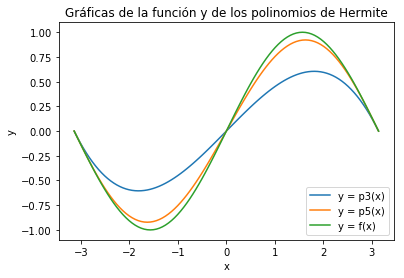

In [310]:
fig, ax = plt.subplots() # Dibujaremos los polinomios de Hermite
ax.plot(xx, yHermiteC1, label = "y = p3(x)"); #  de clase 1 
ax.plot(xx, yHermiteC2, label = "y = p5(x)"); #  de clase 2
ax.plot(xx,yy, label = "y = f(x)"); # y la función f(x)
ax.legend(loc=4);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Gráficas de la función y de los polinomios de Hermite');

Hagamos ahora las comprobaciones oportunas respecto a las condiciones de interpolación impuestas en ambos extremos del intervalo, aunque gráficamente se ve perfectamente que se cumplen.

In [311]:
p3HermiteC1.subs({x:a}),p5HermiteC2.subs({x:a}),f(a)

In [312]:
sp.diff(p3HermiteC1,x).subs({x:a}),sp.diff(p5HermiteC2,x).subs({x:a}),df(a)

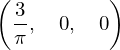

In [313]:
sp.diff(p3HermiteC1,x,2).subs({x:a}),sp.diff(p5HermiteC2,x,2).subs({x:a}),d2f(a)
# Nótese que la que no coincide es la derivada segunda de la cúbica

In [314]:
p3HermiteC1.subs({x:b}),p5HermiteC2.subs({x:b}),f(b)

In [315]:
sp.diff(p3HermiteC1,x).subs({x:a}),sp.diff(p5HermiteC2,x).subs({x:a}),df(a)

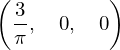

In [316]:
sp.diff(p3HermiteC1,x,2).subs({x:a}),sp.diff(p5HermiteC2,x,2).subs({x:a}),d2f(a)
# Nótese que la que no coincide es la derivada segunda de la cúbica

# Interpolación polinómica de Hermite generalizada

La interpolación de Hermite generalizada consiste en que se satisfagan también datos de ciertas derivadas sucesivas consecutivas de la función a interpolar, aparte de los datos lagrangianos habituales, en los nodos especificados del intervalo considerado. En estos casos impondremos:

$$p^{l)}(x_i)=f^{l)}(x_i),\; l = 0,1,\ldots,m_i\quad i = 0,1,\ldots n $$

# Ejercicios

1.- Se considera la función no negativa 
$e^{\left(-\left(3.9+\frac{5}{2000}\right)t\right)}t^2$. Calcule su polinomio de interpolación en los nodos $0,1,2,3,4,5$. Represéntelo gráficamente y calcule su valor en el punto $4.75$. 


2.- Interpole la función $e^x + \frac{x}{5}$ en los puntos 
$-n,\ldots,-1,0,1,\ldots,n$ para $n=1, 2, 3$. Represente la función y los interpolantes en el intervalo $[-3,3]$ utilizando diferentes colores.

3.- Para la misma función del ejercicio anterior, halle el interpolante de Hermite en el espacio de los polinomios de grado menor o igual que trece para los nodos $-3,-2,-1,0,1,2, 3$. Calcule también el de Taylor en el mismo espacio con nodo $x=0$. Represéntelos en $[-3,3]$. Observe que la función de partida puede ser monótona o convexa y los interpolantes no.

4.- Para qué valores del parámetro $a$ es unisolvente el problema consistente en interpolar en el conjunto de los polinomios de
grado $5$ los datos $g(0),g''(0), g'''(0), g'(1),g'(a), g''(a)$ (problema de Hermite-Birkhoff).

5.- Para qué valores del parámetro $a$ es unisolvente el problema consistente en interpolar en el conjunto de los polinomios de
grado $5$ los datos $g(0),g''(0), g'''''(0), g'(1),g'(a), g''(a)$.